In [1152]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

Merge and import all the data we have

In [1153]:
path = r'/Users/terekhovdmitry/Downloads/Pandas-Data-Science-Tasks-master/Pandas-Data-Science-Tasks-master/SalesAnalysis/Sales_Data'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

Setting the column names to suitable format and cleaning the data

In [1154]:
df.columns = [c.replace(' ', '_') for c in df.columns]
df.columns = map(str.lower, df.columns)


In [1155]:
isNaN = df[df.isna().any(axis=1)]
df = df.dropna(how='all')

In [1156]:
df.isna().sum()

order_id            0
product             0
quantity_ordered    0
price_each          0
order_date          0
purchase_address    0
dtype: int64

Seems like there is no NaN anymore, let's check wrong values

In [1157]:
df.order_id.value_counts().sort_values(ascending=False)

Order ID    355
160873        5
312462        4
194253        4
165665        4
           ... 
212995        1
213013        1
212996        1
212997        1
222909        1
Name: order_id, Length: 178438, dtype: int64

In [1158]:
df = df[df['order_id'].str[0:2] != 'Or']

In [1159]:
df['order_id'] = pd.to_numeric(df['order_id'])
df['quantity_ordered'] = pd.to_numeric(df['quantity_ordered'])
df['price_each'] = pd.to_numeric(df['price_each'])

In [1160]:
df.order_id.value_counts().sort_values(ascending=False)

160873    5
235798    4
196615    4
193511    4
165665    4
         ..
212995    1
213013    1
212996    1
212997    1
222909    1
Name: order_id, Length: 178437, dtype: int64

In [1161]:
df['month'] = (df['order_date'].str[:2]).astype('int32')

In [1162]:
df.isna().sum()

order_id            0
product             0
quantity_ordered    0
price_each          0
order_date          0
purchase_address    0
month               0
dtype: int64

So now all data has been cleaned

### Let's find the best month for sales and and count, how much money we earned this month

In [1163]:
df['sum_column'] = df["price_each"] * df["quantity_ordered"]

In [1164]:
total_by_month = df.groupby('month', as_index=False) \
    .agg({'sum_column': 'sum'})
total_by_month.max()

month              12.00
sum_column    4613443.34
dtype: float64

As we can see we made the most of our sales during December

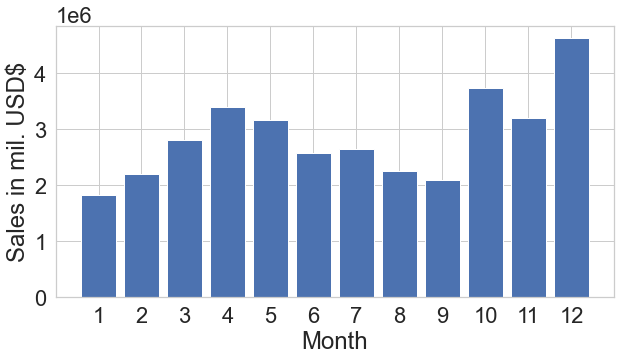

In [1165]:
plt.figure(figsize=(10, 5))
       
plt.bar(months, total_by_month['sum_column'])
plt.xticks(total_by_month['month'])
plt.ylabel('Sales in mil. USD$')
plt.xlabel('Month')

plt.show()

### Let's figure out in which city we made the most of our sales

In [1166]:
df['city'] = df['purchase_address'].str.split(',', expand=True)[1]

In [1167]:
total_by_city = df.groupby('city', as_index=False) \
    .agg({'sum_column': 'sum'})
total_by_city.sort_values('sum_column', ascending=False).head(1)

,city,sum_column
7,San Francisco,8262203.91


We made the most of our sales in San Francisco	

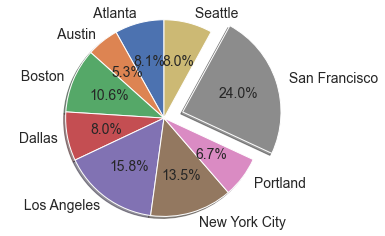

In [1168]:
labels = total_by_city.city
sizes = total_by_city.sum_column 
explode = (0, 0, 0, 0, 0, 0, 0, 0.2, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', 
    textprops={'fontsize': 14}, shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

### What is the best time to display ads to maximize likelihood of customers buying product?

In [1169]:
df['order_date'] = pd.to_datetime(df['order_date'])

In [1170]:
df['hour'] = df['order_date'].dt.hour
df['minutes'] = df['order_date'].dt.minute

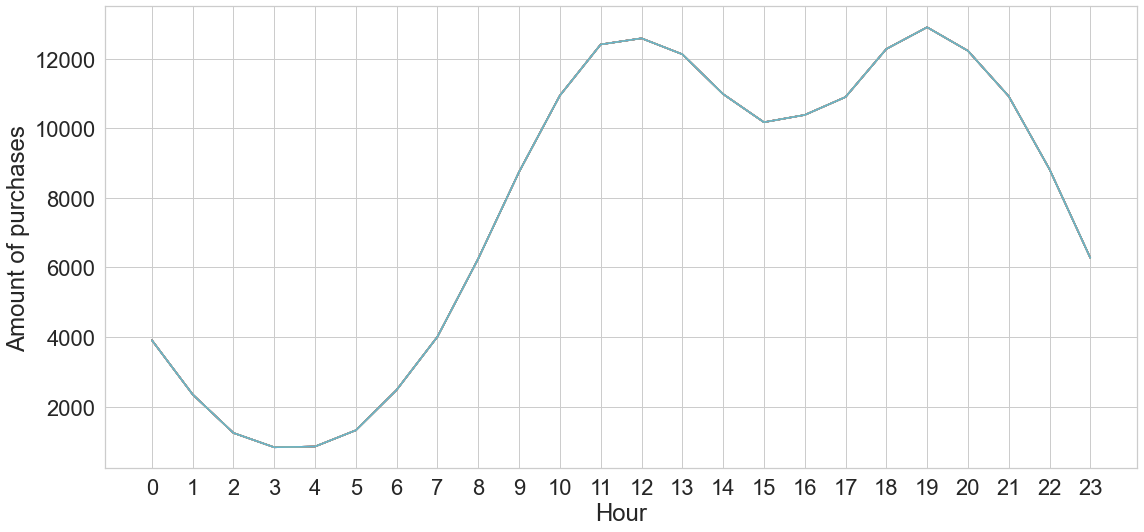

In [1171]:
hours = [hour for hour, df in df.groupby('hour')]

fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)
plt.rcParams.update({'font.size': 22})

plt.plot(hours, df.groupby(['hour']).count())
plt.xticks(hours)
plt.xlabel('Hour')
plt.ylabel('Amount of purchases')


plt.show()

As we can see, the best time to display ads is when people usually have lunch (between 11 and 12) or when they finished working (between 18 and 20)

 ### What products are most often sold together

In [1172]:
items = df.groupby(['order_id', 'order_date'])\
.agg({'product': lambda x: x.ravel().tolist()}).reset_index()
items.head()

,order_id,order_date,product
0,141234,2019-01-22 21:25:00,[iPhone]
1,141235,2019-01-28 14:15:00,[Lightning Charging Cable]
2,141236,2019-01-17 13:33:00,[Wired Headphones]
3,141237,2019-01-05 20:33:00,[27in FHD Monitor]
4,141238,2019-01-25 11:59:00,[Wired Headphones]


In [1173]:
combinations_list = []
for row in items['product']:
    combinations = list(itertools.combinations(row, 2))
    combinations_list.append(combinations)

In [1174]:
combination_counts = pd.Series(combinations_list).explode().reset_index(drop=True)

In [1175]:
combination_counts = combination_counts.value_counts()\
    .head(7)\
    .to_frame()\
    .reset_index()\
    .rename(columns={'index': "product", 0: "amount"})

In [1176]:
combination_counts.head(1)

,product,amount
0,"(iPhone, Lightning Charging Cable)",1005


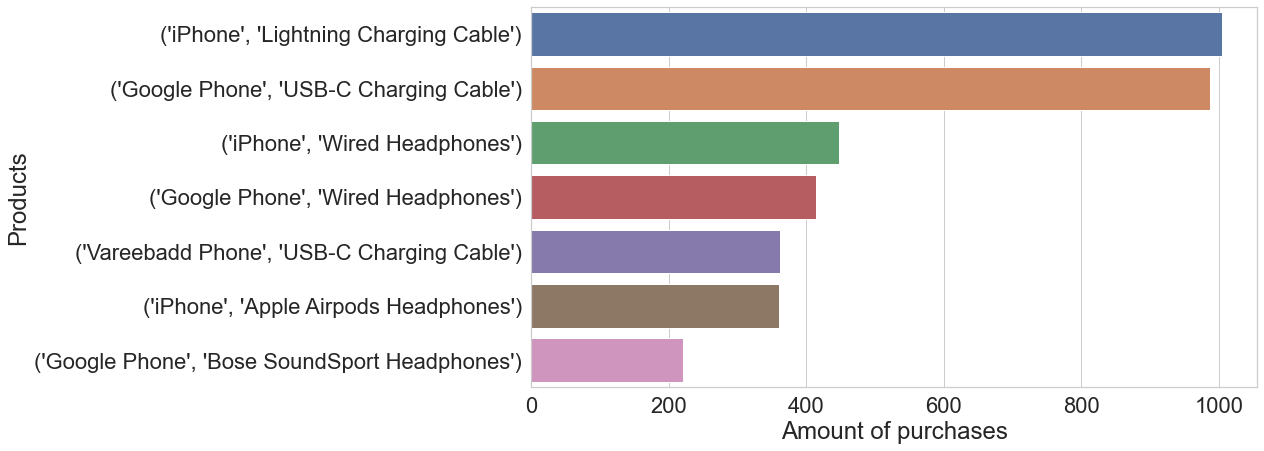

In [1177]:
sns.set_theme(style="whitegrid", font_scale=2)
f, ax = plt.subplots(figsize=(13, 7))
sns.set_color_codes("pastel")


sns.barplot(x="amount", y="product", data=combination_counts,
            label="Total")

ax.set(ylabel="Products",
       xlabel="Amount of purchases")

plt.show()

iPhone, Lightning Charging Cable are most often sold together, with amount of purchases equal 1005 

### What products are sold the most and why?

In [1178]:
most_sold = df.groupby('product')\
    .agg({'quantity_ordered': 'sum'})\
    .rename(columns={'product': "product", "quantity_ordered": "amount"})\
    .reset_index(drop=False)

In [1179]:
most_sold.sort_values('amount', ascending=False).head(3)

,product,amount
5,AAA Batteries (4-pack),31017
4,AA Batteries (4-pack),27635
15,USB-C Charging Cable,23975


In [1180]:
price_info = df.groupby('product')\
    .agg({'price_each': 'mean'})\
    .rename(columns={'product': "product"})\
    .reset_index(drop=False)

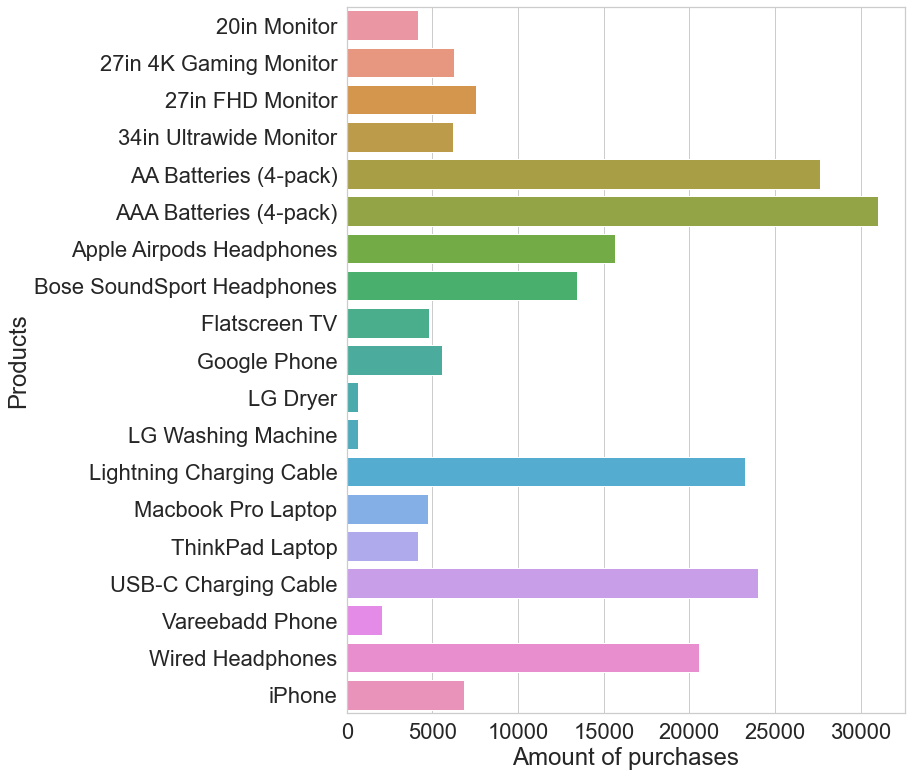

In [1181]:
sns.set_theme(style="whitegrid", font_scale=2)
f, ax = plt.subplots(figsize=(10, 13))
sns.set_color_codes("pastel")


sns.barplot(x="amount", y="product", data=most_sold,
            label="Total")

ax.set(ylabel="Products",
       xlabel="Amount of purchases")

plt.show()

So now, we can clearly say, that amount of sales depends of product price.
But there is also another reason, amount of purchases depends on type of product, because average lifetime of batteries or charging cables much less then lifetime of laptops or phones.

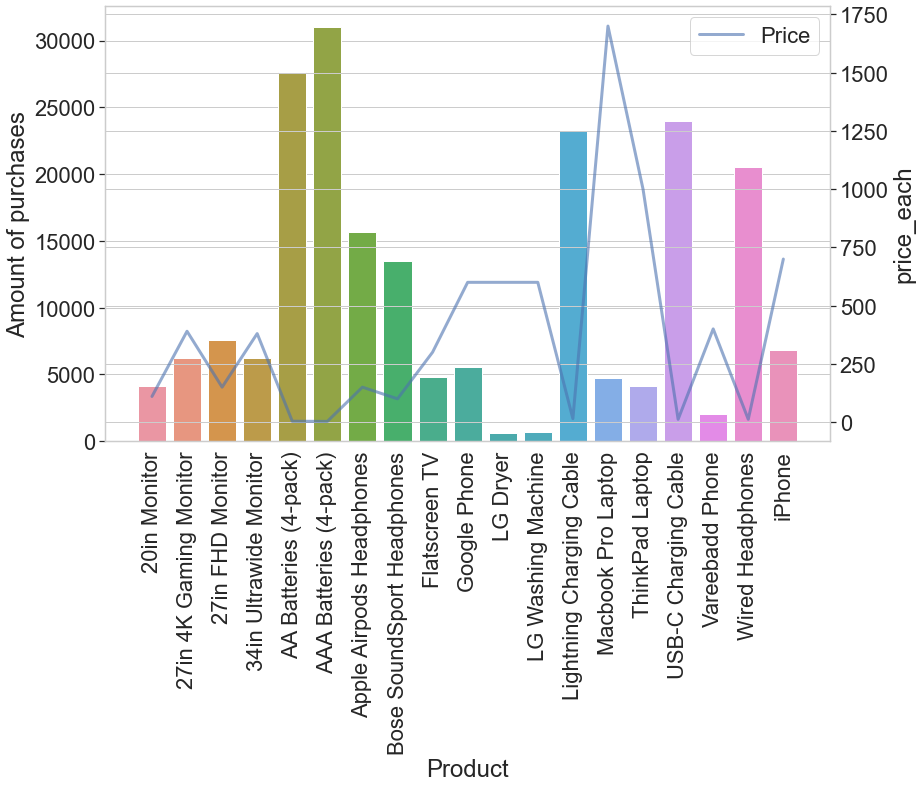

In [1182]:
sns.set_theme(style="whitegrid", font_scale=2)
sns.set_color_codes("pastel")

fig, ax = plt.subplots(figsize=(13, 8))
sns.barplot(x="product", y="amount", data=most_sold, ax=ax, 
            label="Total")
ax2 = ax.twinx()

sns.lineplot(x="product", y="price_each", data=price_info, ax=ax2,
                 linewidth=3, alpha=0.6, label="Price")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

ax.set(ylabel="Amount of purchases",
       xlabel="Product")
    
plt.show()